In [1]:
from mylib import dataset

from dotenv import dotenv_values
from pathlib import Path
from pprint import pprint, pformat

import pandas as pd
import pandas.api.types as pd_types

import numpy as np

import plotly.express as plotly_px

import joblib

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 50) # Устанавливаем максимальное количество отображаемых столбцов равным 50
#pd.set_option('display.max_rows', 50) # Устанавливаем максимальное количество отображаемых строк равным 20
pd.options.display.float_format = '{:.5f}'.format # Устанавливаем формат отображения чисел с двумя знаками после запятой
pd.options.mode.use_inf_as_na = True # Настройка режима Pandas для рассмотрения бесконечностей (inf) как пропущенных значений (NA)

# Конфигурация формата отображения графиков в виде векторных изображений
%config InlineBackend.figure_format = 'svg'

# для построения графиков внутри Jupyter Notebook
%matplotlib inline

plt.rcParams["figure.figsize"] = (14,5) # размер графиков
#plt.style.use('fivethirtyeight') # стиль графиков

# 0. Загрузка конфигов

In [3]:
# загрузить параметры
settings = {
    **dotenv_values("settings")
}
dataset_folder = str(Path(Path.cwd(), settings["DATASET_SUBFOLDER"]))
result_folder = str(Path(Path.cwd(), settings["RESULT_SUBFOLDER"]))

In [4]:
settings

{'DATASET_SUBFOLDER': 'dataset',
 'RESULT_SUBFOLDER': 'result',
 'CACHE_SUBFOLDER': 'cached_results',
 'RANDOM_STATE': '42',
 'DATASET_FILENAME_AFTER_EDA': '01_dataset_df_after_EDA.joblib',
 'PARAMS_FILENAME_AFTER_EDA': '01_params_after_EDA.joblib',
 'DATASET_FILENAME_READY_FOR_TRAIN_ORIGINAL': '02_dataset_catencoder_df_ready_for_train_original.joblib',
 'PARAMS_FILENAME_READY_FOR_TRAIN_ORIGINAL': '02_params_ready_for_train_original.joblib',
 'GRID_SEARCH_TEMPLATE_FILENAME': '03_GridSearch_%s.pickle',
 'MODEL_CLASS_TEMPLATE_FILENAME': '04_model_%s.pickle'}

# 1. Загрузка датасета

In [5]:
dataset_df = pd.read_csv(Path(dataset_folder, 'electric-production.csv')) #, index_col="id")

In [6]:
dataset_df.head(24)

,DATE,IPG2211A2N
0,1/1/1985,72.50520
1,2/1/1985,70.67200
2,3/1/1985,62.45020
3,4/1/1985,57.47140
4,5/1/1985,55.31510
5,6/1/1985,58.09040
6,7/1/1985,62.62020
7,8/1/1985,63.24850
8,9/1/1985,60.58460
9,10/1/1985,56.31540


In [7]:
display(dataset_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


None

Похоже датасет содержит данные о ежемесячном объеме производства электроэнернгии.
В датасете нет пропусков. Дата представлена в строковом виде - нужно преобразовать в дату.

# 2. Преобразование даты в индекс

In [8]:
# Дату в индекс
dataset_df['Date'] = pd.to_datetime(dataset_df['DATE']) # Строки преобразуем в даты
dataset_df.set_index('Date', inplace=True)
dataset_df.drop('DATE', inplace=True, axis=1)
dataset_df.columns = ['EP']

In [9]:
dataset_df

,EP
Date,
1985-01-01,72.50520
1985-02-01,70.67200
1985-03-01,62.45020
1985-04-01,57.47140
1985-05-01,55.31510
...,...
2017-09-01,98.61540
2017-10-01,93.61370
2017-11-01,97.33590


# 3. EDA

In [10]:
display(dataset_df.sample(7))
display(dataset_df.info())

,EP
Date,
2007-10-01,93.00680
1987-09-01,64.11510
1993-12-01,84.22840
2010-11-01,92.77500
2003-11-01,88.57350
1998-08-01,93.53100
1997-02-01,89.77950


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EP      397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


None

In [11]:
# начало измерений
display(dataset_df.sort_index().head(5))

,EP
Date,
1985-01-01,72.50520
1985-02-01,70.67200
1985-03-01,62.45020
1985-04-01,57.47140
1985-05-01,55.31510


In [12]:
# конец измерений
display(dataset_df.sort_index().tail(5))

,EP
Date,
2017-09-01,98.61540
2017-10-01,93.61370
2017-11-01,97.33590
2017-12-01,114.72120
2018-01-01,129.40480


In [13]:
# посмотрим внимательнее на столбец с температурами
display(dataset_df.describe())

,EP
count,397.00000
mean,88.84722
std,15.38783
min,55.31510
25%,77.10520
50%,89.77950
75%,100.52440
max,129.40480


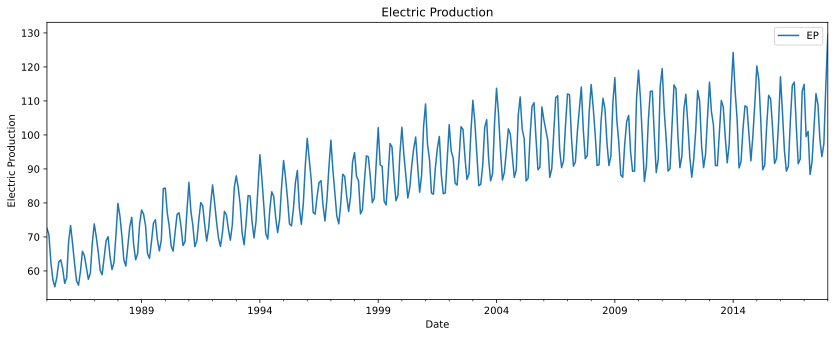

In [14]:
dataset_df.plot(figsize=(14,5), title="Electric Production")
plt.ylabel("Electric Production")
plt.xlabel("Date")
plt.show()

# 3. Анализ временного ряда

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose # оценка сезонности
from statsmodels.tsa.ar_model import AutoReg #AR модель
from scipy.stats import normaltest # критерий Д'Агостино K^2, оценка данных на распределение Гаусса
from statsmodels.tsa.statespace.tools import diff  # разность рядов просто и/или сезонно вдоль нулевой оси
from statsmodels.tsa.arima_model import ARMAResults,ARIMAResults # Получить результаты после fit ARMA, ARIMA
from statsmodels.tsa.arima.model import ARIMA # Построить модель ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX # Построить модель SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # plot_acf график автокорреляции, plot_pacf частичной автокорреляции
from statsmodels.graphics.tsaplots import month_plot,quarter_plot # график сезонности данных по месяцам, кварталам
from pandas.plotting import lag_plot # график лага

from statsmodels.tsa.stattools import adfuller # тест Дики-Фуллера

from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tools.eval_measures import rmse  # метрика качества Квадратный корень из MSE

from pmdarima import auto_arima # автоматический подбор параметров

### Скользящее среднее

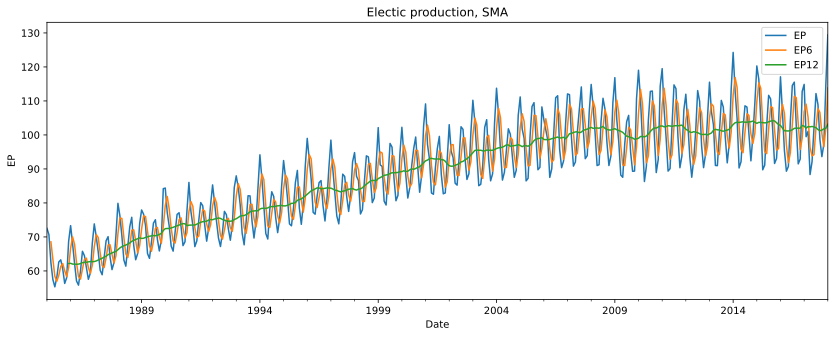

In [16]:
# Простое скользящее среднее (SMA), длинной окна в год
dataset_df_sma = dataset_df.copy()
dataset_df_sma['EP6'] = dataset_df_sma['EP'].rolling(window=3).mean()
dataset_df_sma['EP12'] = dataset_df_sma['EP'].rolling(window=12).mean()
dataset_df_sma.plot(title="Electic production, SMA")
plt.ylabel("EP")
plt.xlabel("Date")
plt.show()

### Сезонная декомпозиция

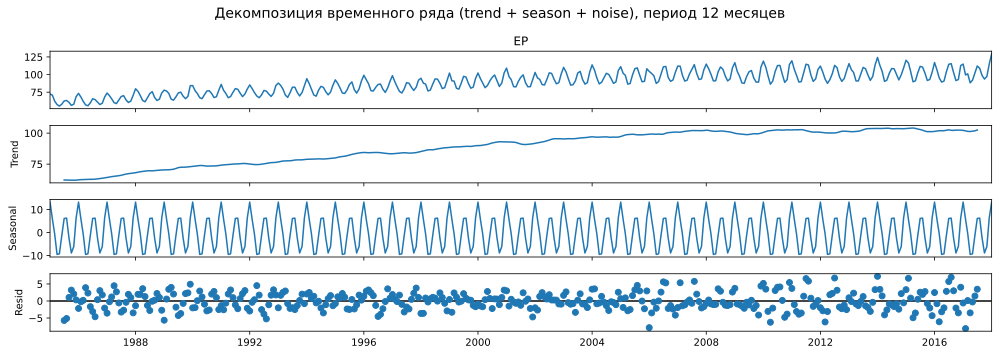

In [17]:
# Декомпозиция
#from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dataset_df["EP"], model='additive', period=12)
decomposition.plot()
plt.suptitle("Декомпозиция временного ряда (trend + season + noise), период 12 месяцев", fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
# Выделим компоненты
trend_part = decomposition.trend
seasonal_part = decomposition.seasonal
residual_part = decomposition.resid

In [19]:
# Посмотрим на начало и конец остатков
print("Ранние значения:")
print(residual_part.head(12))
print("\nПоздние значения:")
print(residual_part.tail(12))

residual_part_clean = residual_part.dropna()

Ранние значения:
Date
1985-01-01        NaN
1985-02-01        NaN
1985-03-01        NaN
1985-04-01        NaN
1985-05-01        NaN
1985-06-01        NaN
1985-07-01   -5.72183
1985-08-01   -5.14645
1985-09-01    1.03332
1985-10-01    3.19742
1985-11-01    2.06619
1985-12-01    0.31638
Name: resid, dtype: float64

Поздние значения:
Date
2017-02-01   -8.10915
2017-03-01    0.12598
2017-04-01   -3.49172
2017-05-01   -0.29429
2017-06-01    1.45811
2017-07-01    3.45952
2017-08-01        NaN
2017-09-01        NaN
2017-10-01        NaN
2017-11-01        NaN
2017-12-01        NaN
2018-01-01        NaN
Name: resid, dtype: float64


### Выводы:
- Мы успешно выделили **тренд**, **сезонность** и **остатки**.
- Остатки содержат NaN в начале и конце, т.к. для вычислений нужны окна (окна симметричны, теряются границы).
- предположительно есть сезонность с периодом 6 или 12 (полугодовая и годовая)
- есть выраженный тренд увеличения выработки электроэнергии из года в год с постепенным выходом на плато к концу датасета

# 4. Стационарность

In [20]:
def adf_test(series, title='', autolag='AIC', maxlag=None):
    '''
    тест Дики-Фуллера
    0 гипотеза: ряд данных не стационарен
    альтернативная гипотеза: ряд данных стационарен
    Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
    @param series - значения ряда
    @param title - заголовок ряда
    '''

    result = adfuller(series.dropna(), autolag=autolag, maxlag=maxlag) # тест предполагает линейный тренд

    labels = ['ADF тест','p-value','# lags used','# наблюдения']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'критическое значение ({key})']=val

    print(out.to_string())

    pvalue = result[1]

    for a in [0.1, 0.5, 0.9, 1.0]:
        print(f"a = {a:.1f} → p-value: {pvalue:.4f} →", "✅ Стационарен" if pvalue < 0.05 else "⚠️ НЕ стационарен")

In [21]:
# тест на стационарность, p-value < 0.05
adf_test(dataset_df['EP'], autolag='aic')

ADF тест                      -2.25699
p-value                        0.18621
# lags used                   15.00000
# наблюдения                 381.00000
критическое значение (1%)     -3.44763
критическое значение (5%)     -2.86916
критическое значение (10%)    -2.57083
a = 0.1 → p-value: 0.1862 → ⚠️ НЕ стационарен
a = 0.5 → p-value: 0.1862 → ⚠️ НЕ стационарен
a = 0.9 → p-value: 0.1862 → ⚠️ НЕ стационарен
a = 1.0 → p-value: 0.1862 → ⚠️ НЕ стационарен


In [22]:
# Выполним дифференцирование и проверим на стационарность
# Дифференцирование
dataset_df['EP_Diff'] = dataset_df['EP'].diff()
# тест на стационарность, p-value < 0.05
adf_test(dataset_df['EP_Diff'], autolag='aic')

ADF тест                      -7.10489
p-value                        0.00000
# lags used                   14.00000
# наблюдения                 381.00000
критическое значение (1%)     -3.44763
критическое значение (5%)     -2.86916
критическое значение (10%)    -2.57083
a = 0.1 → p-value: 0.0000 → ✅ Стационарен
a = 0.5 → p-value: 0.0000 → ✅ Стационарен
a = 0.9 → p-value: 0.0000 → ✅ Стационарен
a = 1.0 → p-value: 0.0000 → ✅ Стационарен


После дифференцирования ряд превращается в стационарный

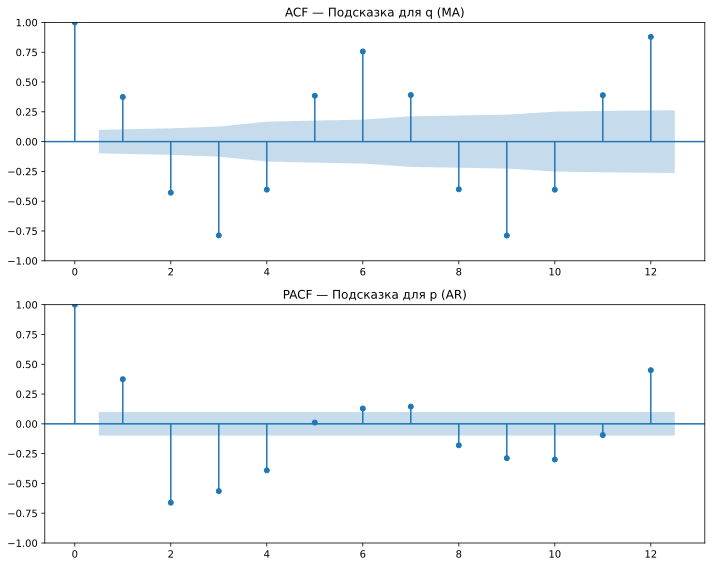

In [23]:
# ACF/PACF
fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(dataset_df['EP_Diff'].dropna(), lags=12, ax=ax[0])
ax[0].set_title("ACF — Подсказка для q (MA)")
plot_pacf(dataset_df['EP_Diff'].dropna(), lags=12, ax=ax[1])
ax[1].set_title("PACF — Подсказка для p (AR)")
plt.tight_layout()
plt.show()

Выводы:
  * без дифференцирования ряд не стационарен. После первого дифференцирования ряд становится стационарным.
  * ACF имеет синусоидальный вид
  * PACF резко обрывается после лага 1.
  * предположительный коэффециент p для AR = 1

# 6. Разделение датасета на тренировочную и тестовую выборки

In [24]:
# выделим два последних года в тестовую выборку
len_test = 24
train1 = dataset_df.head(len(dataset_df)-len_test)
test1 =  dataset_df.tail(len_test)

In [25]:
train1

,EP,EP_Diff
Date,,
1985-01-01,72.50520,NaN
1985-02-01,70.67200,-1.83320
1985-03-01,62.45020,-8.22180
1985-04-01,57.47140,-4.97880
1985-05-01,55.31510,-2.15630
...,...,...
2015-09-01,101.92040,-8.67210
2015-10-01,91.59590,-10.32450
2015-11-01,93.06280,1.46690


In [26]:
test1

,EP,EP_Diff
Date,,
2016-02-01,106.66880,-10.41490
2016-03-01,95.35480,-11.31400
2016-04-01,89.32540,-6.02940
2016-05-01,90.73690,1.41150
2016-06-01,104.03750,13.30060
2016-07-01,114.53970,10.50220
2016-08-01,115.51590,0.97620
2016-09-01,102.76370,-12.75220
2016-10-01,91.48670,-11.27700


# 8. ARIMA

In [27]:
train_arima = train1.copy()
test_arima = test1.copy()

## Подбор параметров

In [28]:
# 🚀 Альтернатива: Автоматический подбор параметров с auto_arima
auto_arima_results = auto_arima(dataset_df['EP'],
                            start_p=0, max_p=5, 
                            start_q=0, max_q=5,
                            seasonal=False,
                            d=1,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)
auto_arima_results.summary()
#print("\n✅ Лучшие параметры ARIMA:", stepwise_model.order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2750.050, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2691.759, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2624.463, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2748.185, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2625.508, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2525.516, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2493.118, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2449.570, Time=0.10 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2449.577, Time=0.08 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2431.710, Time=0.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2431.461, Time=0.10 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2359.635, Time=0.14 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  397
Model:               SARIMAX(2, 1, 4)   Log Likelihood               -1021.362
Date:                Sun, 06 Apr 2025   AIC                           2058.723
Time:                        00:21:31   BIC                           2090.574
Sample:                    01-01-1985   HQIC                          2071.342
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1099      0.023      4.691      0.000       0.064       0.156
ar.L1          0.9985      0.002    511.151      0.000       0.995       1.002
ar.L2         -0.9993      0.001   -766.545      0.000      -1.002      -0.997
ma.L1         -1.3645      0.038    -35.695      0.000      -1.439      -1.290
ma.L2          0.9233      0.071     12.917      0.000       0.783       1.063
ma.L3          0.0070      0.072      0.098      0.922      -0.133       0.147
ma.L4         -0.4339      0.042    -10.269      0.000      -0.517      -0.351
sigma2         9.8954      0.635     15.593      0.000       8.652      11.139
===================================================================================
Ljung-Box (L1) (Q):                   1.04   Jarque-Bera (JB):                21.93
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# Параметры лучшей модели
print(f'Параметры лучшей модели')
print(f'  order: p={auto_arima_results.order[0]}, d={auto_arima_results.order[1]}, q={auto_arima_results.order[2]}')

Параметры лучшей модели
  order: p=2, d=1, q=4


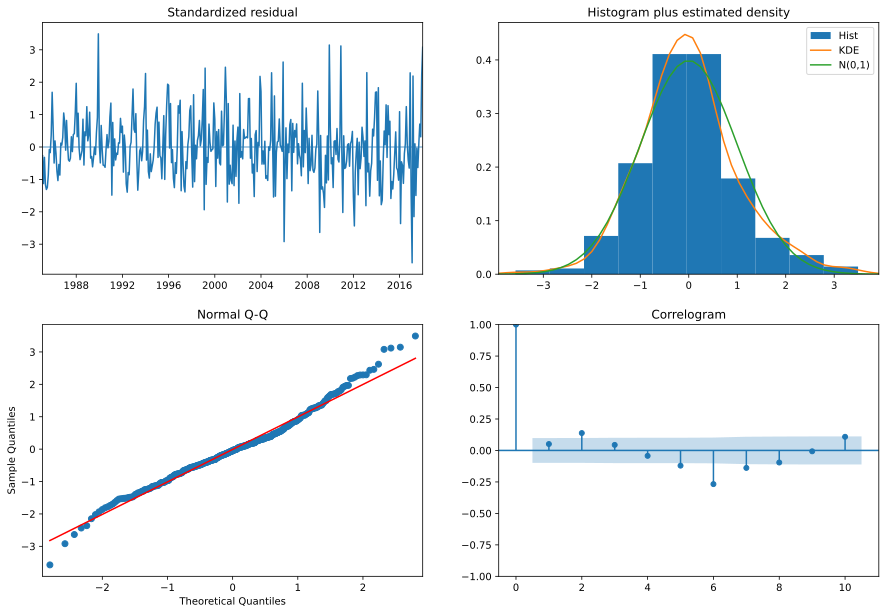

In [30]:
# интерпретация ARIMA модели в виде графиков
auto_arima_results.plot_diagnostics(figsize=(15,10))
plt.show()

## Построение модели

In [31]:
# обучим модель ARIMA используя p,d,q из полученного результата по auto_arima
arima_model= ARIMA(train_arima['EP'], order=auto_arima_results.order)
arima_model_fit= arima_model.fit()

/home/igel/anaconda3/envs/ml/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/igel/anaconda3/envs/ml/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/igel/anaconda3/envs/ml/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/igel/anaconda3/envs/ml/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
# если p-value не менее 0.05 , это означает, что остатки нормально распределены
normaltest(arima_model_fit.resid)

NormaltestResult(statistic=607.7031750996783, pvalue=1.0937856203919047e-132)

In [33]:
# сделаем прогноз на test наборе данных
start= len(train_arima)
end= len(train_arima) + len(test_arima) -1
arima_pred = arima_model_fit.predict(start=start, end=end).rename("ARIMA predictions")

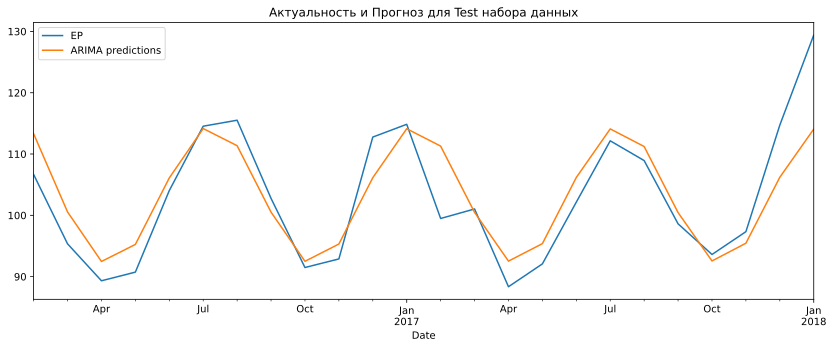

In [34]:
title= "Актуальность и Прогноз для Test набора данных"
test_arima['EP'].plot(title= title, legend=True)
arima_pred.plot(legend=True)
plt.show()

Вроде предстказывает, но визуально ошибка заметная.

# 9. SARIMA

In [35]:
train_sarima = train1.copy()
test_sarima = test1.copy()

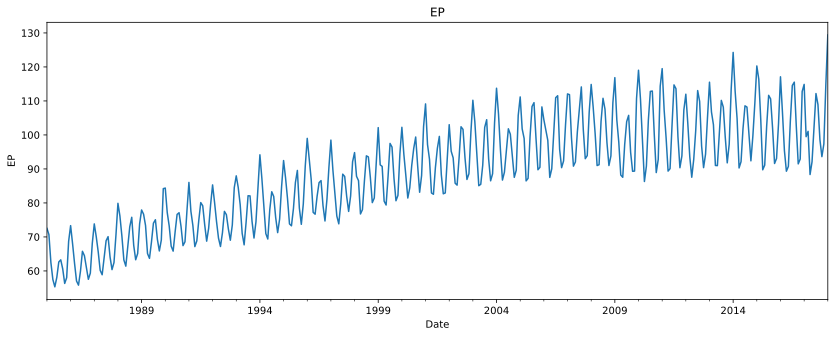

In [36]:
dataset_df['EP'].plot(figsize=(14,5), title="EP")
plt.ylabel("EP")
plt.xlabel("Date")
plt.show()

### Дифференцирование по периоду 6

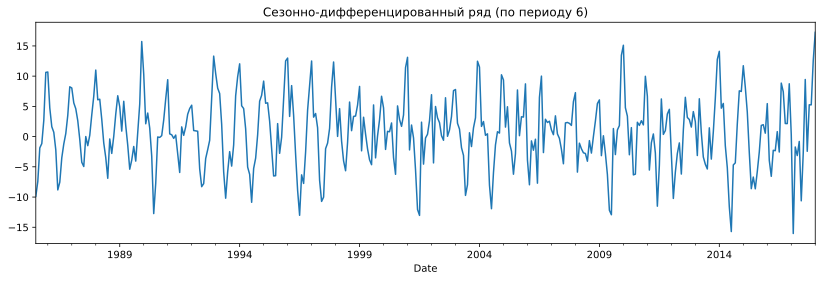

In [37]:
# Дифференцирование по сезону
dataset_df['EP_Diff6'] = dataset_df['EP'] - dataset_df['EP'].shift(6)
dataset_df['EP_Diff6'].dropna().plot(figsize=(14,4), title="Сезонно-дифференцированный ряд (по периоду 6)")
plt.show()

In [38]:
# тест на стационарность, p-value < 0.05
adf_test(dataset_df['EP_Diff6'], autolag='aic')

ADF тест                      -6.73990
p-value                        0.00000
# lags used                   17.00000
# наблюдения                 373.00000
критическое значение (1%)     -3.44800
критическое значение (5%)     -2.86932
критическое значение (10%)    -2.57091
a = 0.1 → p-value: 0.0000 → ✅ Стационарен
a = 0.5 → p-value: 0.0000 → ✅ Стационарен
a = 0.9 → p-value: 0.0000 → ✅ Стационарен
a = 1.0 → p-value: 0.0000 → ✅ Стационарен


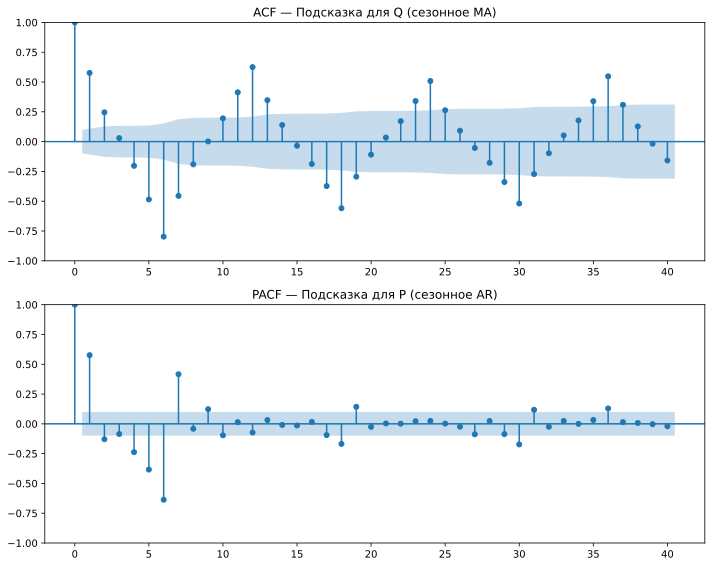

In [39]:
# ACF/PACF
fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(dataset_df['EP_Diff6'].dropna(), lags=40, ax=ax[0])
ax[0].set_title("ACF — Подсказка для Q (сезонное MA)")
plot_pacf(dataset_df['EP_Diff6'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF — Подсказка для P (сезонное AR)")
plt.tight_layout()
plt.show()

ACF сохраняет синусоидальный харарктер

### Дифференцирование по периоду 12

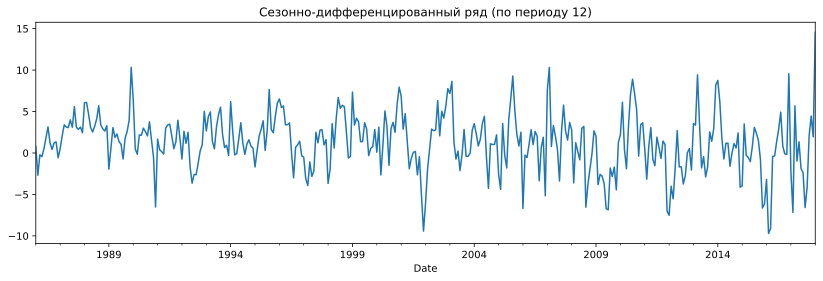

In [40]:
# Дифференцирование по сезону
dataset_df['EP_Diff12'] = dataset_df['EP'] - dataset_df['EP'].shift(12)
dataset_df['EP_Diff12'].dropna().plot(figsize=(14,4), title="Сезонно-дифференцированный ряд (по периоду 12)")
plt.show()

In [41]:
# тест на стационарность, p-value < 0.05
adf_test(dataset_df['EP_Diff12'], autolag='aic')

ADF тест                      -5.67348
p-value                        0.00000
# lags used                   12.00000
# наблюдения                 372.00000
критическое значение (1%)     -3.44805
критическое значение (5%)     -2.86934
критическое значение (10%)    -2.57093
a = 0.1 → p-value: 0.0000 → ✅ Стационарен
a = 0.5 → p-value: 0.0000 → ✅ Стационарен
a = 0.9 → p-value: 0.0000 → ✅ Стационарен
a = 1.0 → p-value: 0.0000 → ✅ Стационарен


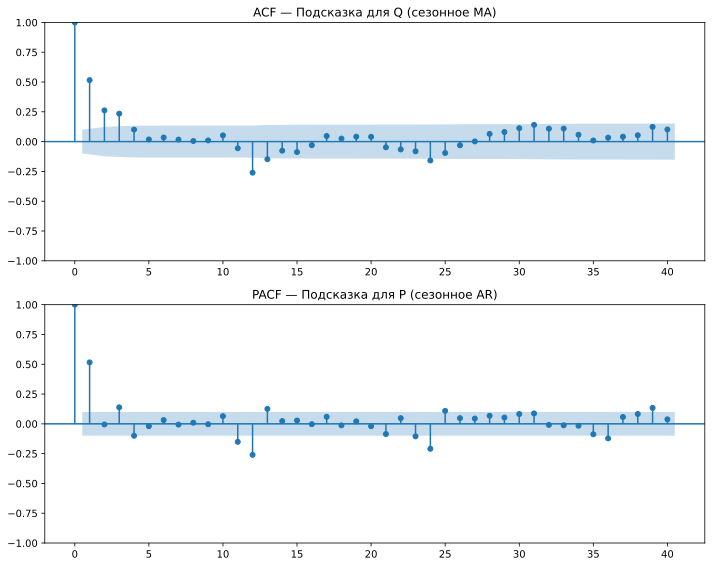

In [42]:
# ACF/PACF
fig, ax = plt.subplots(2, 1, figsize=(10,8))
plot_acf(dataset_df['EP_Diff12'].dropna(), lags=40, ax=ax[0])
ax[0].set_title("ACF — Подсказка для Q (сезонное MA)")
plot_pacf(dataset_df['EP_Diff12'].dropna(), lags=40, ax=ax[1])
ax[1].set_title("PACF — Подсказка для P (сезонное AR)")
plt.tight_layout()
plt.show()

Предположительно Q = 2 или 3, а P = 1


## Подбор параметров для SARIMA

In [43]:
# 🚀 Альтернатива: Автоматический подбор параметров с auto_arima
auto_sarima_results = auto_arima(dataset_df['EP'],
                            start_p=0, max_p=10, 
                            start_q=0, max_q=10,
                            start_P=0, max_P=3,
                            start_Q=0, max_Q=5,
                            m=12,
                            seasonal=True,
                            d=None,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True,
                            n_jobs=-1)
auto_sarima_results.summary()
#print("\n✅ Лучшие параметры ARIMA:", stepwise_model.order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2750.050, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2401.309, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2748.185, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2624.463, Time=0.03 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1923.996, Time=0.25 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2050.756, Time=0.11 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=1925.269, Time=0.57 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1924.712, Time=0.79 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2322.293, Time=0.27 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2007.513, Time=0.33 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1947.697, Time=0.17 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1868.993, Time=0.36 sec
 ARIMA(1,1,1)(0,0,1)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  397
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -926.366
Date:                              Sun, 06 Apr 2025   AIC                           1866.732
Time:                                      00:21:50   BIC                           1894.602
Sample:                                  01-01-1985   HQIC                          1877.773
                                       - 01-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0006      0.001      0.456      0.648      -0.002       0.003
ar.L1          0.3576      0.089      4.021      0.000       0.183       0.532
ma.L1         -0.7217      0.087     -8.276      0.000      -0.893      -0.551
ma.L2         -0.2252      0.078     -2.890      0.004      -0.378      -0.072
ar.S.L12       0.9923      0.005    187.979      0.000       0.982       1.003
ma.S.L12      -0.7287      0.043    -17.137      0.000      -0.812      -0.645
sigma2         5.9086      0.342     17.260      0.000       5.238       6.580
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                26.70
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.94   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
# Параметры лучшей модели
print(f'Параметры лучшей модели')
print(f'  order: p={auto_sarima_results.order[0]}, d={auto_sarima_results.order[1]}, q={auto_sarima_results.order[2]}')
print(f'  seasonal_order: P={auto_sarima_results.seasonal_order[0]}, D={auto_sarima_results.seasonal_order[1]}, ' +
      f'Q={auto_sarima_results.seasonal_order[2]}, s={auto_sarima_results.seasonal_order[3]}')

Параметры лучшей модели
  order: p=1, d=1, q=2
  seasonal_order: P=1, D=0, Q=1, s=12


### Построение модели SARIMA

In [45]:
# обучим модель ARIMA используя p,d,q из полученного результата по auto_arima
sarima_model= SARIMAX(train_sarima['EP'], order=auto_sarima_results.order, seasonal_order=auto_sarima_results.seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

/home/igel/anaconda3/envs/ml/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/igel/anaconda3/envs/ml/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [46]:
# если p-value не менее 0.05 , это означает, что остатки нормально распределены
normaltest(sarima_model_fit.resid)

NormaltestResult(statistic=697.4739185562555, pvalue=3.511259682393711e-152)

In [47]:
# сделаем прогноз на test наборе данных
start= len(train_sarima)
end= len(train_sarima) + len(test_sarima) -1
sarima_pred = sarima_model_fit.predict(start=start, end=end).rename("SARIMA predictions")

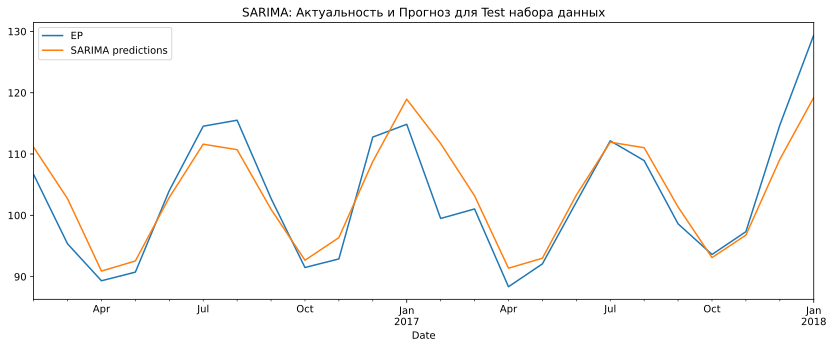

In [48]:
title= "SARIMA: Актуальность и Прогноз для Test набора данных"
test_sarima['EP'].plot(title= title, legend=True)
sarima_pred.plot(legend=True)
plt.show()

# Оценка качества моделей

### Визуальное сравнение

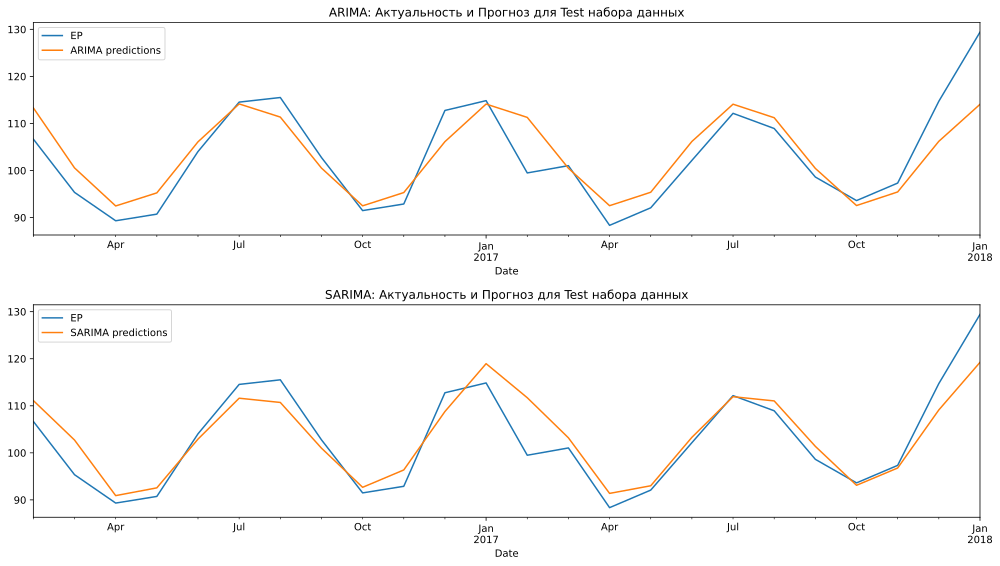

In [68]:
# ACF/PACF
fig, ax = plt.subplots(2, 1, figsize=(14,8))
test_arima['EP'].plot(legend=True, ax=ax[0])
arima_pred.plot(legend=True, ax=ax[0])
ax[0].set_title("ARIMA: Актуальность и Прогноз для Test набора данных")
test_sarima['EP'].plot(legend=True, ax=ax[1])
sarima_pred.plot(legend=True, ax=ax[1])
ax[1].set_title("SARIMA: Актуальность и Прогноз для Test набора данных")
plt.tight_layout()
plt.show()

### Метрики

In [75]:
# Функция для вычисления метрик
def evaluate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}


# Оценка метрик
arima_metrics = evaluate_metrics(test_arima["EP"], arima_pred)
sarima_metrics = evaluate_metrics(test_sarima["EP"], sarima_pred)

print("ARIMA:")
pprint(arima_metrics)
print("SARIMA:")
pprint(sarima_metrics)
print(f"ARIMA AIC: {arima_model_fit.aic}, SARIMA AIC: {sarima_model_fit.aic}")
print(f"ARIMA BIC: {arima_model_fit.bic}, SARIMA BIC: {sarima_model_fit.bic}")


ARIMA:
{'MAE': 3.9947933052350613,
 'MAPE': 3.8007063286733747,
 'MSE': 28.684804638708925,
 'RMSE': 5.355819698114279}
SARIMA:
{'MAE': 3.3325970356808234,
 'MAPE': 3.1699511614906424,
 'MSE': 19.791754877214178,
 'RMSE': 4.4487925190116675}
ARIMA AIC: 1914.917779118003, SARIMA AIC: 1706.6759564453494
ARIMA BIC: 1942.3500360979149, SARIMA BIC: 1730.1893195709881


SARIMA показывает чуть лучшие метрики, чем ARIMA

### Анализ остатков

In [109]:
sarima_residuals = sarima_model_fit.resid
arima_residuals = arima_model_fit.resid
df_residuals = pd.DataFrame({'ARIMA': arima_residuals, 'SARIMA': sarima_residuals})

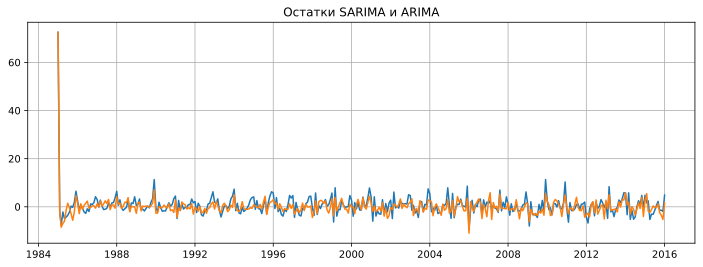

In [118]:
# График остатков
plt.figure(figsize=(12, 4))
plt.plot(df_residuals.index, df_residuals)
plt.title("Остатки SARIMA и ARIMA")
plt.grid(True)
plt.show()

График остатков выглядит как случайный, без выраженных паттернов

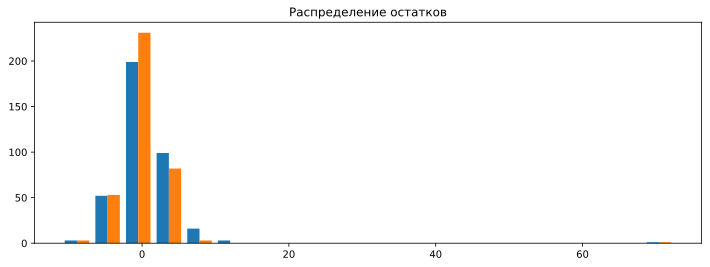

In [89]:
# Гистограмма и QQ-plot
from scipy.stats import probplot
plt.figure(figsize=(12, 4))
plt.hist(df_residuals, bins=20)
plt.title('Распределение остатков')
plt.show()

Распределение остатков обеих моделей выглядят как нормальное.

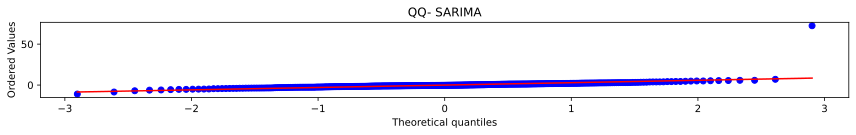

In [103]:
plt.figure(figsize=(12, 2))
probplot(df_residuals["SARIMA"], plot=plt)
plt.title('QQ- SARIMA')
plt.tight_layout()
plt.show()

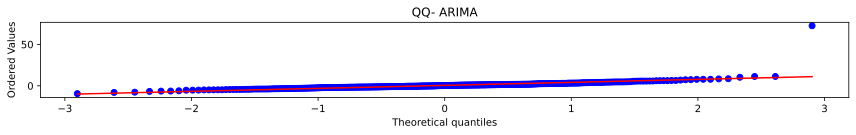

In [102]:
plt.figure(figsize=(12, 2))
probplot(df_residuals["ARIMA"], plot=plt)
plt.title('QQ- ARIMA')
plt.tight_layout()
plt.show()

Все точки остатков в обеих моделях находятся на прямой - можно сделать вывод, что остатки распределены нормально.

### Тест Льюинга-Бокса

In [123]:
from statsmodels.stats.diagnostic import acorr_ljungbox
arima_lb_test = acorr_ljungbox(df_residuals["ARIMA"], lags=[10], return_df=True)
lb_pvalue_arima = arima_lb_test['lb_pvalue'].values[0]
print(f"ARIMA: p-value теста Льюнга-Бокса для ARIMA: {lb_pvalue_arima}. {'Остатки не случайны' if lb_pvalue_arima < 0.05 else 'Остатки случайны'}")
sarima_lb_test = acorr_ljungbox(df_residuals["SARIMA"], lags=[10], return_df=True)
lb_pvalue_sarima = sarima_lb_test['lb_pvalue'].values[0]
print(f"SARIMA: p-value теста Льюнга-Бокса для SARIMA: {lb_pvalue_sarima}. {'Остатки не случайны' if lb_pvalue_sarima < 0.05 else 'Остатки случайны'}")

ARIMA: p-value теста Льюнга-Бокса для ARIMA: 0.022512807586711186. Остатки не случайны
SARIMA: p-value теста Льюнга-Бокса для SARIMA: 0.5547153997987465. Остатки случайны
